In [1]:
from pprint import PrettyPrinter as PrettyPrinter
pp = PrettyPrinter(indent=4)

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import numpy as np
import pylab as pl
import random
from time import time

import twitter

from scipy.cluster.hierarchy import dendrogram, linkage

CONSUMER_KEY = 'FOCsEQzKgiGsmcKjGfIxCMvzG'
CONSUMER_SECRET = '1b7vcnfWi0XB2ToWg6DyExUPJyJChQNlI80hk9cRFBgeGDP5hP'
ACCESS_TOKEN_KEY = '2389226360-hx1JtwawH75LNKmgi0x5Ec5qHw15yLRn6hqpQQP'
ACCESS_TOKEN_SECRET = 'pq26olnBNatEEORQM4fVDbDsBmvCpfnxTvYB9Rw9AKNpu'

api = twitter.Api(consumer_key=CONSUMER_KEY,
                      consumer_secret=CONSUMER_SECRET,
                      access_token_key=ACCESS_TOKEN_KEY,
                      access_token_secret=ACCESS_TOKEN_SECRET)

SEED = 111

In [2]:
stemmer = PorterStemmer()
def _tokenize(text):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if w.isalnum()]
    stems = []
    for item in tokens:
        stems.append(stemmer.stem(item))
    return stems

In [7]:
def _getTweets(url, iterationCount, count):
    tweets = []
    results = api.GetSearch(raw_query=url)
    for result in results:
            tweets.append(result.full_text)
    while len(tweets) < count and iterationCount > 0:
        ids = [result.id for result in results]
        minId = min(ids)-1
        results = api.GetSearch(raw_query=url + "&max_id=" + str(minId))
        for result in results:
            tweets.append(result.full_text)
        iterationCount -= 1
    return tweets

In [10]:
tweets = []
iterationCount = 10;
nbaTweets = _getTweets("q=nba&tweet_mode=extended&count=100", iterationCount, 1000)
logangTweets = _getTweets("q=logang&tweet_mode=extended&count=100", iterationCount, 1000)

In [15]:
tweets = nbaTweets + logangTweets

In [16]:
vectorizer = TfidfVectorizer(tokenizer=_tokenize, stop_words='english')
X = vectorizer.fit_transform(tweets)
print("done")

done


In [57]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, verbose=False)

print("Clustering")
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

Clustering
done in 0.151s


For n_clusters = 2 The average silhouette_score is : 0.0175500886152


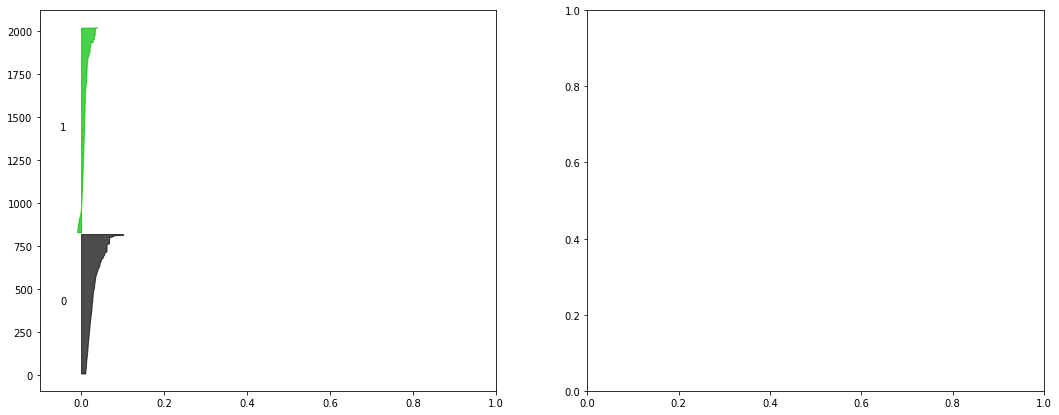

For n_clusters = 3 The average silhouette_score is : 0.0250291905842


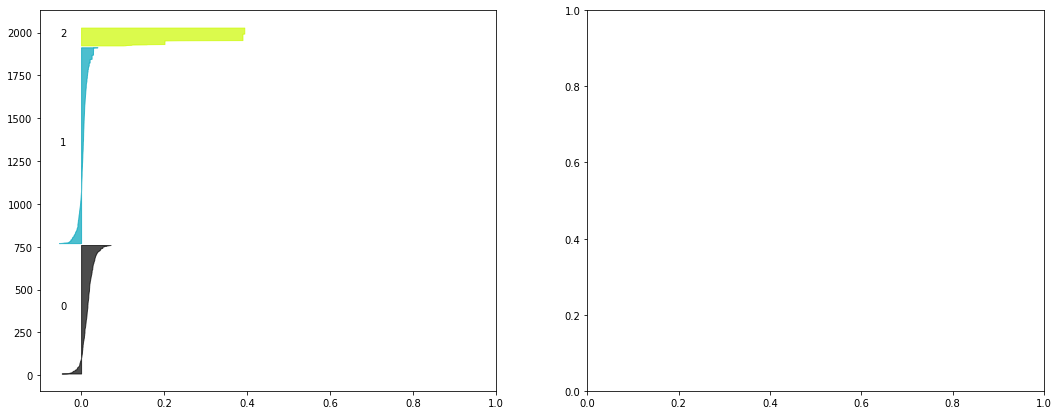

For n_clusters = 4 The average silhouette_score is : 0.0243566036542


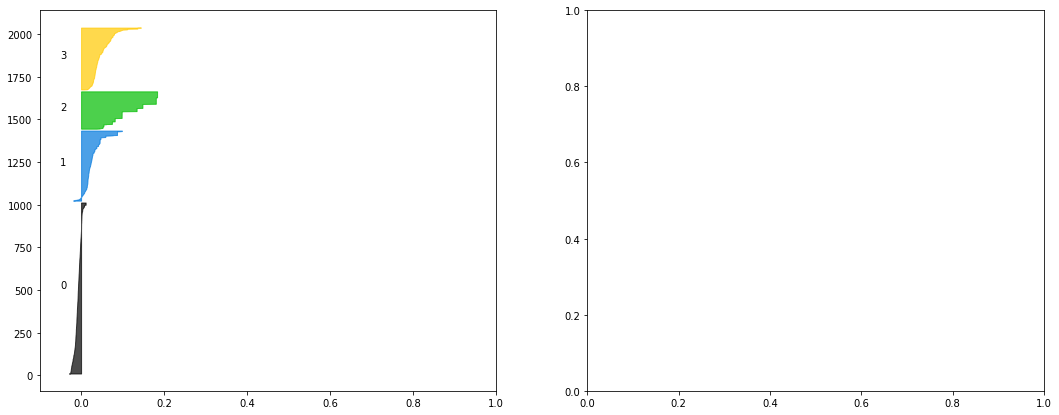

For n_clusters = 5 The average silhouette_score is : 0.0358060182225


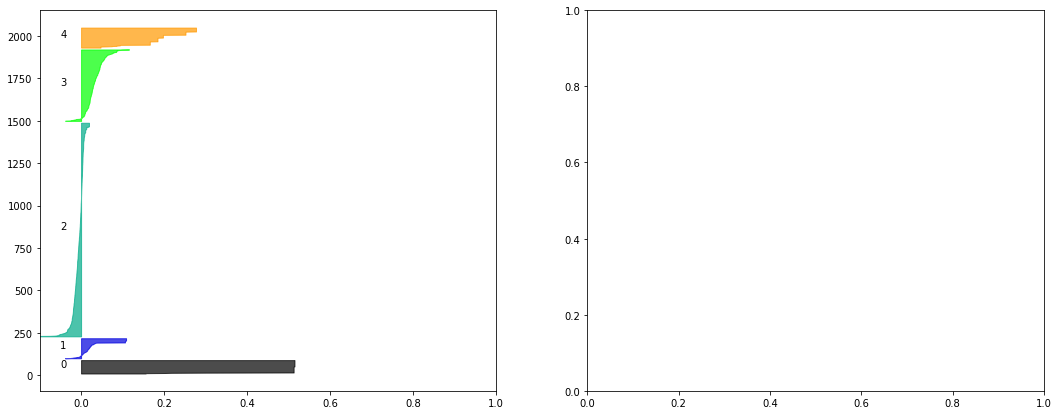

For n_clusters = 6 The average silhouette_score is : 0.0351598192521


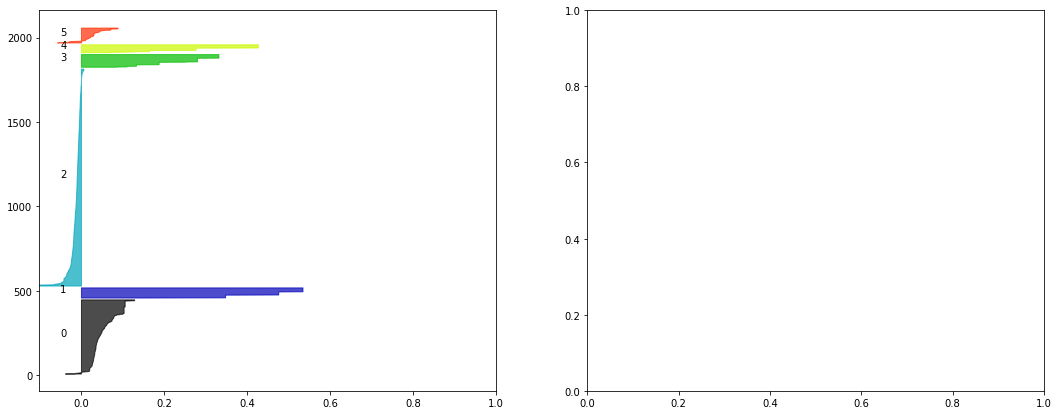

In [20]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1, verbose=False)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
    plt.show()

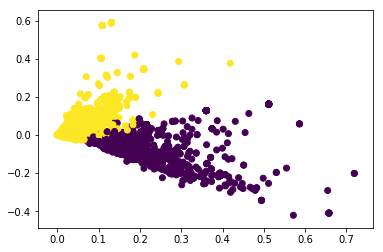

In [58]:
model = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=100, random_state=SEED, tol=0.0)
svd = model.fit_transform(X)
pl.figure('K-means')
pl.scatter(svd[:, 0], svd[:, 1], c=km.labels_)
pl.show()

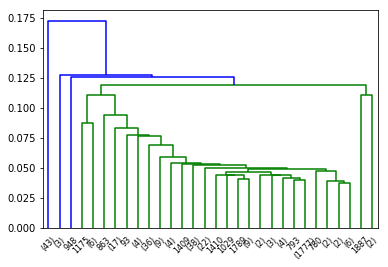

In [59]:
Z = linkage(svd, 'single')
dendrogram(Z,  leaf_font_size=8, truncate_mode='lastp', p=30, orientation='top')
plt.show()

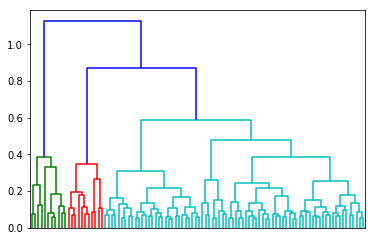

In [60]:
Z = linkage(svd, 'complete')
dendrogram(Z,  leaf_font_size=8, truncate_mode='lastp', p=100, orientation='top', no_labels=True)
plt.show()